In [2]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [3]:
# THE DQN MODULE IMPLEMENTED USING PYTORCH FRAMEFORK
class DeepQNetwork(nn.Module):
    def __init__(self, ALPHA, input_dims, fc1_dims, fc2_dims,         # initialises the DQN with the input dims.
                 n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=ALPHA)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cuda:1')
        self.to(self.device)

    def forward(self,state):                       # returns Q values corresponding to  # various actions available in state .
        x = F.relu(self.fc1(state.float()))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)
        return actions

In [4]:
class Agent(object):
    def __init__(self, gamma, epsilon, alpha, input_dims, batch_size, n_actions,   # initialises the agent
                 max_mem_size=100000, eps_end=0.01, eps_dec= 5e-1):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.alpha = alpha
        self.action_space = [i for i in range(n_actions)]
        self.n_actions = n_actions
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0   # stores the index of the element to remove and replace from the replay memory.
        self.Q_eval = DeepQNetwork(alpha, n_actions=self.n_actions,                 # the running Q network
                              input_dims=input_dims, fc1_dims=256, fc2_dims=256)


        self.Q_train= DeepQNetwork(alpha, n_actions=self.n_actions,
                                   input_dims=input_dims, fc1_dims=256, fc2_dims=256)  # the target Q network

        self.Q_train.load_state_dict(self.Q_eval.state_dict())   #using same weights for both
        self.Q_train.eval()     # setting training net to eval mode


        self.state_memory = np.zeros((self.mem_size, *input_dims),dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims),dtype=np.float32)               # replay memory in form of for arrays
        self.action_memory = np.zeros(self.mem_size,
                                      dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size,dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)   # to check if the state is ending state or not

    def storeTransition(self, state, action, reward, state_, done):   # removes one element from replay memory and adds a new one
        index = self.mem_cntr % self.mem_size   # to see which element to remove from the memory.
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.new_state_memory[index] = state_
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def chooseAction(self, observation):
        rand = np.random.random()
        if rand>self.epsilon:
            state=T.tensor(np.array([observation])).to(self.Q_eval.device)    # convert observation to tensor
            actions=self.Q_eval.forward(state) # Q values corresponding to different actions
            action=T.argmax(actions)
        else:
            action = np.random.choice(self.action_space)
        return action


    def learn(self):
            if self.mem_cntr<self.batch_size:
                return

            max_mem=min(self.mem_cntr,self.mem_size)
            batch = np.random.choice(max_mem, self.batch_size)
            batch_index=np.arange(self.batch_size,dtype=np.int32)

            state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
            new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
            reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
            terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)
            action_batch= self.action_memory[batch]

            self.Q_eval.optimizer.zero_grad()

            q_eval = self.Q_eval.forward(state_batch)[batch_index,action_batch] # slicing to get the values
                                                                                # corresponding to taken actions only.

            q_next = self.Q_train.forward(new_state_batch)
            q_next[terminal_batch]=0.0

            q_target= reward_batch+ self.gamma * T.max(q_next,dim=1)[0]

            loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
            loss.backward()
            self.Q_eval.optimizer.step()

            if self.epsilon > self.eps_min :
                self.epsilon-=self.eps_dec

In [7]:
import pandas as pd
df=pd.read_csv('GOOGl.csv')
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
3267,2022-12-23,87.110001,89.550003,87.070000,89.230003,89.230003,23003000
3268,2022-12-27,88.800003,88.940002,87.010002,87.389999,87.389999,20097300
3269,2022-12-28,86.980003,88.040001,85.940002,86.019997,86.019997,19523200
3270,2022-12-29,86.620003,88.849998,86.610001,88.449997,88.449997,23333500
3271,2022-12-30,86.980003,88.300003,86.570000,88.230003,88.230003,23986300


In [8]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,15.689439,15.753504,15.621622,15.684434,15.684434,78169752
1,2010-01-05,15.695195,15.711712,15.554054,15.615365,15.615365,120067812
2,2010-01-06,15.662162,15.662162,15.174174,15.221722,15.221722,158988852
3,2010-01-07,15.250250,15.265265,14.831081,14.867367,14.867367,256315428
4,2010-01-08,14.814815,15.096346,14.742492,15.065566,15.065566,188783028


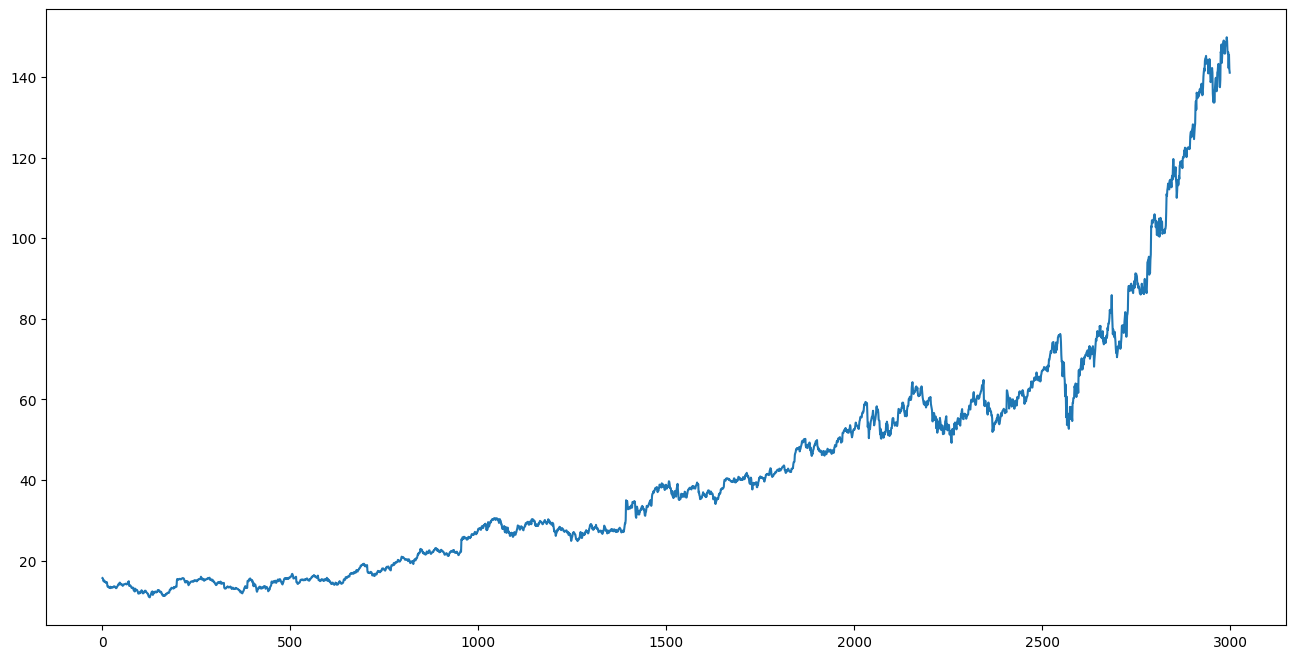

In [9]:
total=df.shape[0]
rel=df['Adj Close'][:3000]
total=3000
train_size= (int)(total*1.0)
train=rel[:train_size]

train_vec=(list)(train)

import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(np.arange(train_size),train)

<class 'float'>


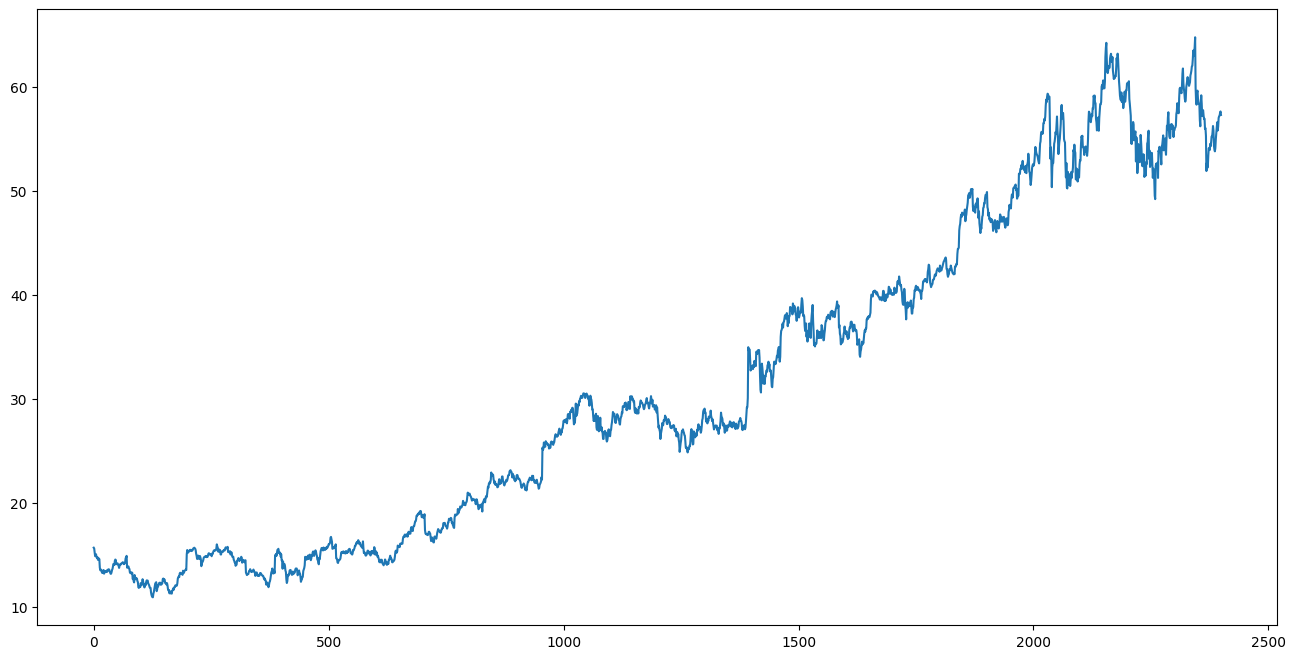

In [10]:
total=3000
rel=df['Adj Close'][:total]
train_size= (int)(total*0.8)
train=rel[:train_size]
test=rel[train_size:]
test_vec=(list)(test)
train_vec=(list)(train)
print(type(test_vec[0]))
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(np.arange(train_size),train)

In [11]:
def upd_state(data,time,action,curr_stocks,n,tr_count,total_money,max_trans):
    state= np.array(data[time-n+1:time])
    worth_today= total_money+curr_stocks*data[time-1]
    if(action==0):
        curr_stocks+= ((total_money)/(max_trans-tr_count))/data[time-1]
        total_money-= ((total_money)/(max_trans-tr_count))
        tr_count+=1
    elif(action==1):
        total_money+=(data[time-1]*curr_stocks)
        curr_stocks=0
        tr_count=0
    worth_tomorrow=total_money+curr_stocks*data[time]
    if(data[time]>=data[time-1]):
        opt_action=0
    if(data[time]<data[time-1]):
        opt_action=1
    state=np.append(state,curr_stocks)
    reward= (worth_tomorrow-worth_today)
    return (reward,state,curr_stocks,tr_count,total_money,opt_action)

In [12]:
num_episodes=50
profits=[]
data=train_vec
data_size=len(data)
state_size= 50
steps_upd_target=20  # steps after which target network should be updated
max_trans =50
total_money=10000
agent=Agent(gamma=0.95, epsilon=1, alpha=0.001, input_dims=[state_size], batch_size=32, n_actions=3,   # initialises the agent
                 max_mem_size=1000, eps_end=0.01, eps_dec= 2e-5)
for ep in np.arange(num_episodes):
    print("EPISODE",ep+1)
    time=state_size
    State=np.array(data[time-state_size+1:time],dtype=np.float32)
    State=np.append(State,0)
    curr_stocks= (float)(0)
    tr_count=0
    ep_reward=0
    total_money=10000
    dicti={0:"Buy",1:"Sell",2:"Hold"}
    while(time<data_size):
        action=agent.chooseAction(State)
        if(action==0 and tr_count<max_trans):
            action=0
        elif(action==0 and tr_count==max_trans):
            action=2

        reward,new_state,curr_stocks,tr_count,total_money,opt_action=upd_state(data,time,action,curr_stocks,state_size,tr_count,total_money,max_trans)
        agent.storeTransition(State, action, reward, new_state,0)
        agent.learn()
        State=new_state
        ep_reward+=reward
        if(time%steps_upd_target==0):
             agent.Q_train.load_state_dict(agent.Q_eval.state_dict())
        time+=1
#         print(" TIME = ",time,"Action Taken = ",dicti[(int)(action)],"Action Expected =",dicti[opt_action],"Reward = ",reward)


    profits.append(ep_reward)
    net= total_money+curr_stocks*data[-1]
    print("Reward in Episode",ep+1,"=",ep_reward,"and net amount=",net,"epsilon = ",agent.epsilon)







EPISODE 1
Reward in Episode 1 = 554.5199756928996 and net amount= 10554.5199756929 epsilon =  0.9536199999999536
EPISODE 2
Reward in Episode 2 = 779.6722701455201 and net amount= 10779.67227014552 epsilon =  0.9066199999999066
EPISODE 3
Reward in Episode 3 = 300.70668118260437 and net amount= 10300.706681182604 epsilon =  0.8596199999998596
EPISODE 4
Reward in Episode 4 = 343.2181499914659 and net amount= 10343.218149991466 epsilon =  0.8126199999998126
EPISODE 5
Reward in Episode 5 = 1046.0280216451683 and net amount= 11046.028021645168 epsilon =  0.7656199999997656
EPISODE 6
Reward in Episode 6 = 256.95707911958743 and net amount= 10256.957079119587 epsilon =  0.7186199999997186
EPISODE 7
Reward in Episode 7 = 1306.4680241028418 and net amount= 11306.468024102842 epsilon =  0.6716199999996716
EPISODE 8
Reward in Episode 8 = 898.2959521866251 and net amount= 10898.295952186625 epsilon =  0.6246199999996246
EPISODE 9
Reward in Episode 9 = 716.1309164896702 and net amount= 10716.1309164

In [13]:
data=test_vec
data_size=len(data)
data_size
print(len(test_vec))
state_size= 50
max_trans =50
total_money=10000
time=state_size
State=np.array(data[time-state_size+1:time],dtype=np.float32)
State=np.append(State,0)
curr_stocks= (float)(0)
tr_count=0
Reward=0
dicti={0:"Buy",1:"Sell",2:"Hold"}
while(time<data_size):
        action=agent.chooseAction(State)
        if(action==0 and tr_count<max_trans):
            action=0
        elif(action==0 and tr_count==max_trans):
            action=2

        reward,new_state,curr_stocks,tr_count,total_money,opt_action=upd_state(data,time,action,curr_stocks,state_size,tr_count,total_money,max_trans)
        print(" TIME = ",time,"Action Taken = ",dicti[(int)(action)],"Action Expected =",dicti[opt_action])

        State=new_state
        Reward+=reward
        time+=1
#         print(Reward)


net= total_money+curr_stocks*data[-1]
print("Reward = ",Reward,"and net amount=",net)





600
 TIME =  50 Action Taken =  Hold Action Expected = Sell
 TIME =  51 Action Taken =  Hold Action Expected = Sell
 TIME =  52 Action Taken =  Hold Action Expected = Sell
 TIME =  53 Action Taken =  Hold Action Expected = Sell
 TIME =  54 Action Taken =  Hold Action Expected = Buy
 TIME =  55 Action Taken =  Hold Action Expected = Buy
 TIME =  56 Action Taken =  Hold Action Expected = Sell
 TIME =  57 Action Taken =  Hold Action Expected = Sell
 TIME =  58 Action Taken =  Hold Action Expected = Buy
 TIME =  59 Action Taken =  Hold Action Expected = Buy
 TIME =  60 Action Taken =  Hold Action Expected = Buy
 TIME =  61 Action Taken =  Hold Action Expected = Buy
 TIME =  62 Action Taken =  Hold Action Expected = Buy
 TIME =  63 Action Taken =  Hold Action Expected = Buy
 TIME =  64 Action Taken =  Hold Action Expected = Buy
 TIME =  65 Action Taken =  Sell Action Expected = Sell
 TIME =  66 Action Taken =  Hold Action Expected = Sell
 TIME =  67 Action Taken =  Hold Action Expected = Se